# Demonstrating each step which `DNASnake` takes to go from `polygon` -> `scaffold route`

Note: `DNASnake` is a subclass of `Lattice`

In [177]:
from drawNA.oxdna import System, POS_STACK, round_to_multiple
from drawNA.lattice import LatticeNode, LatticeRoute, Lattice
from drawNA.polygons import BoundaryPolygon

import matplotlib.pyplot as plt

import numpy as np

from bisect import bisect_left, bisect_right
from os import path

ROOT = "/".join(path.abspath('').split("/"))

# 1. Firstly, we create an instance of the `Lattice` class

In [178]:
# Triangle (in reduced units of sigma)
triangle = np.array([[0,0,0],[5,9,0],[10,0,0]])
polygon = triangle*5
# POS_STACK value = 0.34, each key word here is assigned its default value
x_spacing, y_spacing = POS_STACK, 1.00
grid_size = [x_spacing, y_spacing]
lattice = Lattice(polygon, grid_size, bp_per_turn = 10.45, start_side="left")

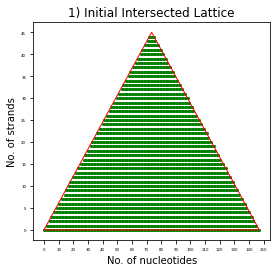

In [179]:
# This is what the initial "intersected lattice" looks like in comparison to initial polygon
lattice.plot([lattice.intersected_coords], poly = True, title = "1) Initial Intersected Lattice")

### 1a) Make grid to overlay on polygon

In [180]:
# Calculate bounds of the grid around the polygon
x_min, y_min, x_max, y_max = lattice.polygon.bounds
x_min = round_to_multiple(x_min, x_spacing)
x_max = round_to_multiple(x_max, x_spacing)
y_min = round_to_multiple(y_min, y_spacing)
y_max = round_to_multiple(y_max, y_spacing)

# Initialise large grid of points spaced using x & y spacing
# This is to "quantise" our grid
x_grid = np.linspace(x_min, x_max, int((x_max - x_min) / x_spacing) + 2)
y_grid = np.linspace(y_min, y_max, int((y_max - y_min) / y_spacing) + 1)
bounds_grid = np.transpose(
    [np.tile(x_grid, len(y_grid)),
        np.repeat(y_grid, len(x_grid))])

from shapely.geometry import MultiPoint
points = MultiPoint(bounds_grid)
points = np.array(points.__geo_interface__["coordinates"])/[0.34,1.00]
x_min = points[:, 0].min()
y_min = points[:, 1].min()

# shift points to (0,0)
points[:, 0] -= x_min
points[:, 1] -= y_min


### 1b) plot `points` and `polygon` with show intersected points 

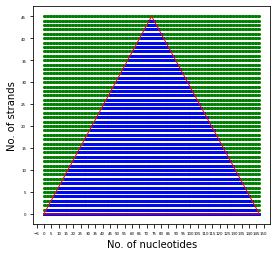

In [181]:
lattice.plot([points, lattice.intersected_coords], poly = True, ticks = [5,5])

# Note: the blue intersected points are calculated using shapely.geometry's `intersection`

# 2) We 'quantise' each row (i.e. round the number of lattice sites on each row)
        
i.e. Ensure first and last scaffold site in the row correlate to a position where the **half turn crossover** most likely occurs. `poss_cross` is a list containing these locations and this can be tailored for the system we want, in this case, it is only half turn crossover locations, i.e. 0.5, 1.5, 2.5 turns.

Values are rounded up OR down to the closest half turn location and then rows are modified by adding/removing 1 lattice site at a time in an alternating fashion from left to right.

Half turn row sizes (where we begin counting at 0): [0, 4, 15, 25, 36, 46, 56, 67, 77, 88, 98, 109, 119, 130, 140, 151, 161, 171, 182, 192] 



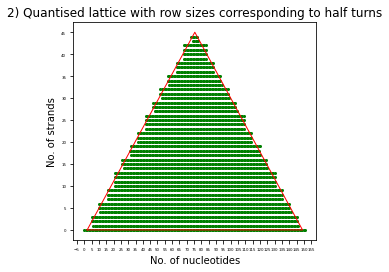

In [182]:
""" Step 2 """
# Defined in the __init__ function
padding = 30

poss_cross = lattice.poss_cross
print("Half turn row sizes (where we begin counting at 0): %s \n" % poss_cross)
lattice.quantised_array = lattice.quantise_rows(lattice.intersected_array, poss_cross, padding)

# See plot and compare with previous plot
lattice.plot([lattice.quantised_array], poly = True, ticks = [5,5], title = "2) Quantised lattice with row sizes corresponding to half turns")

# 3) Connect each row  
This is done by filtering through each row, from the bottom up:

## Step 1
We need to decide on what side to start at, either left (default) or right - let's start at the left, meaning: end --> right side

## Step 2
Hence, we seek to connect the right side of row 0 to row 1, which we do by: 
    
 - CONDITION i -> when row 0 and row 1 are of the same size  
    
        - do nothing (apart from the last step - shifting)

 - CONDITION ii -> when row 0 > row 1 (by 2+ crossovers) either:
        
        a) Make the end of row 0 SMALLER by a number of extra crossovers  
        b) Make the end of row 0 SMALLER by 1 crossover size -> only where row 0 is shorter than 4 crossovers in length (since this tends to shorten the row too much)
    
 - CONDITION iii -> when row 0 < row 1 (by 2+ crossover) either:
        
        a) Make the end of row 0 LONGER by a number of extra crossovers
        b) Make the end of row 0 LONGER by 1 crossover size -> where row 0 is shorter than 4 crossovers in length (since this tends to skew the end of the shape)

- CONDITION iv -> when row 0 > row 1 (by ONE crossover only):

        a) if row -1 == row 1 == row 2: shorten row 0 by one crossover
        b) elif row -1 == row -2 AND row 1 == row 2: shorten both rows 0 and 1 by 1 crossover if row 1 > 2 crossovers (~16nt) otherwise shorten just row 0 by one crossover
        c) elif row 0 == 4 crossovers (~36nt) AND row 1 == row 2: lengthen row 1 by one crossover
        

- CONDITION v -> when row 0 < row 1 (by ONE crossover only):

        a) if row 1 == row 2 AND row 1 < the last 10 rows: shorten row 1 by one crossover
        b) if row 2 == row 1 or 0: shorten row 1 by one crossover

- NO CONDITION -> ALWAYS SHIFT row 1 to line up with the end of row 0

## Step 3
Move to the next row, switch the starting side from "left" -> "right" or vice versa

- "next row" means -> old row 1 = row 0 and old row 2 = row 1 etc.

Then calculate row sizes and repeat `Step 2`

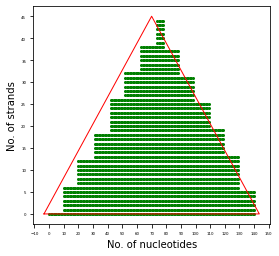

In [183]:
# Run the above rules on the current lattice:
lattice.connected_array = lattice.connect_rows(lattice.quantised_array, half_turn_locations = poss_cross, bp_per_turn = 10.45, start_side="left",)
lattice.final_array = lattice.connected_array
lattice.plot([lattice.connected_array], poly = True)

# 4) Find crossovers

This is achieved by cycling through each row:

1. Finding the first lattice site (from the `start_side`, i.e. left or right)
2. At crossover locations (counting from the first lattice site) represent it as a crossover site IF a lattice site also exists at that point

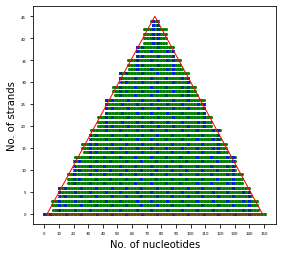

In [184]:
""" Step 4 """
lattice.crossover_array = lattice.get_crossovers(lattice.final_array, lattice.start_side, lattice.poss_cross)

# Lattice and Crossovers as coordinates
lattice.final_coords = lattice.array_to_coords(lattice.final_array)
lattice.crossover_coords = lattice.array_to_coords(lattice.crossover_array)
lattice.plot([lattice.quantised_array,lattice.crossover_coords], aspect = 3)

# 5) Generate route from crossovers

Again, by cycling through each row, in the crossover lattice:

1. Find the first and last crossovers, starting from the `start_side` (either left or right)
2. Add these locations to a `vertex_list` (where the distances between each vertex is counted in number of nucleotides.
3. Change the `start_side` and repeat the cycle

Finally, convert each vertex in this list into a `LatticeNode` and generate a `LatticeRoute` from these nodes which are in order. This new object has a property which allows us to generate DNA strands using our `generate_helix` function.

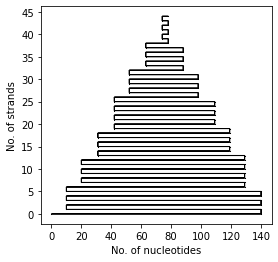

In [185]:
""" Step 5 Routing Algorithm"""
coords = lattice.crossover_coords
# add 3rd column (z = 0)
shape = np.shape(coords)
if shape[1] != 3:
    coords = np.c_[coords, np.zeros(shape[0])]

crossovers_per_row = 2
no_of_lattice_rows = int(coords[:, 1].max() + 1)  # coords counts from 0
vertices_in_route = int(crossovers_per_row * no_of_lattice_rows)
vertex_list = np.zeros((vertices_in_route, 3))

# Find final crossover from left or right and make it a node
for row in range(0, no_of_lattice_rows):
    vertex_index_L = bisect_left(coords[:, 1], row)
    vertex_index_R = bisect_right(coords[:, 1], row) - 1
    if row % 2 == 0:  # if even
        vertex_list[row * 2] = coords[vertex_index_L]
        vertex_list[row * 2 + 1] = coords[vertex_index_R]
    else:  # if odd
        vertex_list[row * 2] = coords[vertex_index_R]
        vertex_list[row * 2 + 1] = coords[vertex_index_L]

# print(vertex_list)

node_list = [LatticeNode(i) for i in vertex_list]

route = LatticeRoute(node_list)

""" Route """
route.plot(aspect = 3)


# 6) Generate a DNA Strand from `LatticeRoute`

i.e. -> to LAMMPS & oxDNA files

This is achieved by the following:  
- Generating a single strand for every horizontal edge (from the route plot)  

  1. find the `pos_back` (position of the backbone) of the final nt in the previous strand
  2. adjust the `start_position` of the next strand using `pos_back` AND reverse the `direction` of the next strand
  3. repeat steps 1 and 2 until strands for the entire route have been generated

- Generate a single strand for the entire scaffold (from the collection of single strands and all the nucleotides within)

In [186]:

# nodes = [
#     LatticeNode(np.array([9., 1., 0.])),
#     LatticeNode(np.array([14., 1., 0.])),
#     LatticeNode(np.array([14., 2., 0.])),
#     LatticeNode(np.array([9., 2., 0.])),
#     LatticeNode(np.array([9., 3., 0.])),
#     LatticeNode(np.array([14., 3., 0.])),
#     LatticeNode(np.array([14., 4., 0.])),
#     LatticeNode(np.array([9., 4., 0.])),
#     LatticeNode(np.array([9., 5., 0.])),
#     LatticeNode(np.array([25., 5., 0.])),
#     LatticeNode(np.array([25., 6., 0.])),
#     LatticeNode(np.array([0., 6., 0.])),
#     LatticeNode(np.array([0., 7., 0.])),
#     LatticeNode(np.array([25., 7., 0.])),
#     LatticeNode(np.array([25., 8., 0.])),
#     LatticeNode(np.array([0., 8., 0.])),
#     LatticeNode(np.array([0., 9., 0.])),
#     LatticeNode(np.array([25., 9., 0.])),
#     LatticeNode(np.array([25., 10., 0.])),
#     LatticeNode(np.array([0., 10., 0.])),
#     LatticeNode(np.array([0., 11., 0.])),
#     LatticeNode(np.array([16., 11., 0.])),
#     LatticeNode(np.array([16., 12., 0.])),
#     LatticeNode(np.array([11., 12., 0.])),
#     LatticeNode(np.array([11., 13., 0.])),
#     LatticeNode(np.array([16., 13., 0.])),
#     LatticeNode(np.array([16., 14., 0.])),
#     LatticeNode(np.array([11., 14., 0.])),
#     LatticeNode(np.array([11., 15., 0.])),
#     LatticeNode(np.array([16., 15., 0.])),
#     LatticeNode(np.array([16., 16., 0.])),
#     LatticeNode(np.array([11., 16., 0.])),
# ]

# route = LatticeRoute(nodes)

# system = System(np.array([50., 50., 50.]))
# system.add_strand(route)
# system = route.system(box=np.array([50., 50., 50.]))
# system.write_oxDNA(prefix="manual",root=ROOT)

In [187]:
## Write to file

system = route.system()
system.write_oxDNA(prefix="notebook_example", root=ROOT)
system.write_LAMMPS(prefix="notebook_example", root=ROOT)

